Same as the first xgboost, but add datetime related features such as month and dayofweek.

Model improves only slightly. 

In [1]:
import numpy as np
import math

import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

data.head(5)

In [3]:
import re
def add_datepart(df, fldname, drop=True, time=False, lower=True):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    if lower: attr = [_.lower() for _ in attr]
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if lower:
        df[targ_pre + 'elapsed'] = fld.astype(np.int64) // 10 ** 9
    else:
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [4]:
#data['month'] = data.date.dt.month
#data['dayofweek'] = data.date.dt.dayofweek

add_datepart(data, 'date', drop=False)
data.drop(['year', 'week', 'day', 'dayofyear', 'elapsed'], axis=1, inplace=True)  # I think these features will cause 1-on-1 mapping
data.head()

,date,high,low,open,close,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999,1,3,False,False,False,False,False,False
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002,1,4,False,False,False,False,False,False
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998,1,0,False,False,False,False,False,False
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002,1,1,False,False,False,False,False,False
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000,1,2,False,False,False,False,False,False


In [5]:
col_dates = data.columns.to_list()
col_dates = ['date'] + col_dates[-8:]
col_dates

['date',
 'month',
 'dayofweek',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start']

### Modelling

In [6]:
# initial/dryrun parameters
N = 4  # from last xgboost
seed = 42

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 0.8                # Subsample ratio of the training instance. default = 1
colsample_bytree = 0.8         # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

In [7]:
# functions to wrap lines

def get_mov_avg_std(df, col, N):

    df_out = df.copy()
    df_out[col + '_mean'] = df[col].rolling(window = N, min_periods=1).mean().shift()
    df_out[col + '_std'] = df[col].rolling(window = N, min_periods=1).std().shift()
    
    return df_out


def scale_row(row, feat_mean, feat_std):

    feat_std = 0.001 if feat_std == 0 else feat_std    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=42, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0,
                          name='xgb'):

    model = XGBRegressor(objective='reg:squarederror', # silent=True
                         seed=seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled * col_std + col_mean

    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred

#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params_tuning(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();

### Feature Engineering

* Difference between high and low of each day
* Difference between open and close of each day


In [8]:
# Get difference between high and low of each day
data['range_hl'] = data['high'] - data['low']
data.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
data['range_oc'] = data['open'] - data['close']
data.drop(['open', 'close'], axis=1, inplace=True)

data.head()

data_copy = data.copy()

,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,range_hl,range_oc
0,2014-01-02,5404200,57.439999,1,3,False,False,False,False,False,False,3.570004,-3.160000
1,2014-01-03,4118700,56.740002,1,4,False,False,False,False,False,False,2.450001,0.849998
2,2014-01-06,11791700,51.259998,1,0,False,False,False,False,False,False,3.620003,2.990002
3,2014-01-07,6661900,52.490002,1,1,False,False,False,False,False,False,1.829998,-0.340000
4,2014-01-08,4930200,51.680000,1,2,False,False,False,False,False,False,1.480000,0.610001


### Get mean and std dev at timestamp t using values from t-1, ..., t-N

The most important part, we will set the anchoring point for the forcasting

In [9]:
data = data_copy.copy()
cols_list = "volume adj_close range_hl range_oc".split()

for col in cols_list:
    data = get_mov_avg_std(data, col, N)
data.head()

,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,...,range_hl,range_oc,volume_mean,volume_std,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std
0,2014-01-02,5404200,57.439999,1,3,False,False,False,False,False,...,3.570004,-3.160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,4118700,56.740002,1,4,False,False,False,False,False,...,2.450001,0.849998,5.404200e+06,NaN,57.439999,NaN,3.570004,NaN,-3.160000,NaN
2,2014-01-06,11791700,51.259998,1,0,False,False,False,False,False,...,3.620003,2.990002,4.761450e+06,9.089858e+05,57.090000,0.494973,3.010002,0.791962,-1.155001,2.835497
3,2014-01-07,6661900,52.490002,1,1,False,False,False,False,False,...,1.829998,-0.340000,7.104867e+06,4.109493e+06,55.146666,3.384101,3.213336,0.661540,0.226667,3.122024
4,2014-01-08,4930200,51.680000,1,2,False,False,False,False,False,...,1.480000,0.610001,6.994125e+06,3.362689e+06,54.482500,3.065816,2.867501,0.877589,0.085000,2.564820


In [10]:
data['order_day'] = list(range(len(data)))
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

In [11]:
for shift in range(1,N+1):
    
    data_shift = data[merging_keys + lag_cols].copy()
    data_shift['order_day'] = data_shift['order_day'] + shift
    
    foo = lambda x: f'{x}_lag_{shift}' if x in lag_cols else x
    data_shift = data_shift.rename(columns=foo)

    data = pd.merge(data, data_shift, on=merging_keys, how='left')
    
del data_shift

# Remove the first N rows which contain NaNs
data = data[N:]

In [12]:
data.head(5)

,date,volume,adj_close,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,...,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_lag_4,range_hl_lag_4,range_oc_lag_4,volume_lag_4
4,2014-01-08,4930200,51.680000,1,2,False,False,False,False,False,...,2.990002,11791700.0,56.740002,2.450001,0.849998,4118700.0,57.439999,3.570004,-3.160000,5404200.0
5,2014-01-09,4159900,52.110001,1,3,False,False,False,False,False,...,-0.340000,6661900.0,51.259998,3.620003,2.990002,11791700.0,56.740002,2.450001,0.849998,4118700.0
6,2014-01-10,2829700,51.970001,1,4,False,False,False,False,False,...,0.610001,4930200.0,52.490002,1.829998,-0.340000,6661900.0,51.259998,3.620003,2.990002,11791700.0
7,2014-01-13,4422500,49.860001,1,0,False,False,False,False,False,...,-0.080002,4159900.0,51.680000,1.480000,0.610001,4930200.0,52.490002,1.829998,-0.340000,6661900.0
8,2014-01-14,4564000,51.049999,1,1,False,False,False,False,False,...,0.340000,2829700.0,52.110001,1.039997,-0.080002,4159900.0,51.680000,1.480000,0.610001,4930200.0


In [13]:
# Split into train, val, and test sets

# the test set size decreases by N, not very important here 
train = data[:ntrain]
val = data[ntrain:ntrain+nval]
train_val = data[:ntrain+nval] # convinient
test = data[ntrain+nval:]
print("Dataset Size:")
print("Train: {} | Validation: {} | Test: {}".format(train.shape[0],
                                                       val.shape[0],
                                                      test.shape[0]))

Dataset Size:
Train: 891 | Validation: 297 | Test: 293


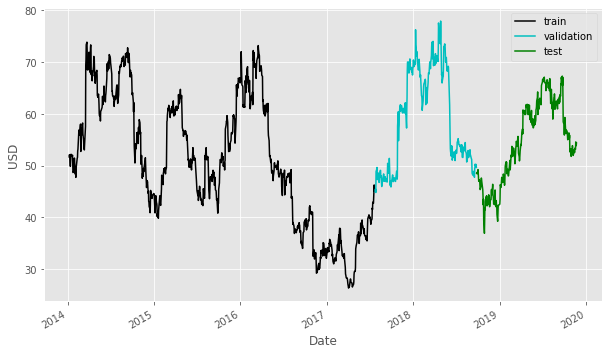

In [14]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

In [15]:
# scale the train, val, and test sets

cols_to_scale = ["adj_close"]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[col_dates] = train.reset_index()[col_dates]
train_scaled.head()

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,...,volume_lag_4,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,0.070099,0.134412,0.038738,-0.296133,1.587583,0.035313,1.760422,2.397236,3.693882,0.473860,...,1.049789,2014-01-08,1,2,False,False,False,False,False,False
1,0.104584,0.069446,-0.298904,0.475301,0.865542,0.133973,0.036617,-0.298295,1.571415,0.034315,...,0.518119,2014-01-09,1,3,False,False,False,False,False,False
2,0.093356,0.103934,-0.723373,-0.085005,0.544362,0.069002,-0.300438,0.470700,0.854920,0.132972,...,3.691596,2014-01-10,1,4,False,False,False,False,False,False
3,-0.075859,0.092705,-0.462905,0.256051,-0.010272,0.103493,-0.724168,-0.087835,0.536207,0.068003,...,1.569961,2014-01-13,1,0,False,False,False,False,False,False
4,0.019575,-0.076528,0.752614,1.652749,0.653854,0.092263,-0.464153,0.252144,-0.014167,0.102493,...,0.853747,2014-01-14,1,1,False,False,False,False,False,False


In [16]:
# Do scaling for train+val set
scaler_train_val = StandardScaler()
train_val_scaled = scaler_train_val.fit_transform(train_val[cols_to_scale])

# Convert the numpy array back into pandas dataframe
train_val_scaled = pd.DataFrame(train_val_scaled, columns=cols_to_scale)
train_val_scaled[col_dates] = train_val.reset_index()[col_dates]
train_val_scaled.head()

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,...,volume_lag_4,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,-0.093294,-0.027676,-0.018302,-0.291441,1.738254,-0.127690,1.616170,2.307006,3.941467,0.317115,...,1.176640,2014-01-08,1,2,False,False,False,False,False,False
1,-0.058356,-0.093491,-0.338551,0.451933,0.984735,-0.027747,-0.020303,-0.292923,1.723329,-0.128149,...,0.621114,2014-01-09,1,3,False,False,False,False,False,False
2,-0.069731,-0.058552,-0.741154,-0.087993,0.649553,-0.093563,-0.340281,0.448799,0.974538,-0.028208,...,3.936986,2014-01-10,1,4,False,False,False,False,False,False
3,-0.241171,-0.069928,-0.494103,0.240658,0.070740,-0.058623,-0.742543,-0.089927,0.641458,-0.094023,...,1.720153,2014-01-13,1,0,False,False,False,False,False,False
4,-0.144482,-0.241372,0.658801,1.586554,0.763819,-0.069999,-0.495701,0.237994,0.066277,-0.059085,...,0.971802,2014-01-14,1,1,False,False,False,False,False,False


In [17]:
# Do scaling for val set
val_scaled = val[col_dates]
for col in cols_list:
    feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
    temp = val.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    val_scaled = pd.concat([val_scaled, temp], axis=1)

val_scaled.head()

,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,volume_lag_1,...,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
895,2017-07-24,7,0,False,False,False,False,False,False,-0.969569,...,0.410948,-1.316610,-1.295494,0.034644,0.117773,1.143077,1.386003,-0.081863,-0.318975,-0.985165
896,2017-07-25,7,1,False,False,False,False,False,False,-0.893260,...,1.294676,0.262373,-1.291020,-0.288712,0.757183,0.822549,0.314762,1.266366,-0.636847,-0.944282
897,2017-07-26,7,2,False,False,False,False,False,False,-0.389305,...,-0.550431,1.406664,-0.754440,-0.799491,0.236463,1.317468,-0.112729,0.037579,1.258857,-1.183706
898,2017-07-27,7,3,False,False,False,False,False,False,-1.079047,...,-1.190962,-0.461356,-0.970078,-0.179635,-0.251509,1.401222,0.204560,-0.886397,-0.643969,1.325805
899,2017-07-28,7,4,False,False,False,False,False,False,1.486065,...,0.876630,-0.586963,1.483782,-0.701289,-0.376479,-0.406014,1.417744,-0.021157,-0.782933,-0.613654


In [18]:
# Do scaling for test set
test_scaled = test[col_dates]
for col in cols_list:
    feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
test_scaled.head()

,date,month,dayofweek,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,volume_lag_1,...,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4
1192,2018-09-26,9,2,False,False,False,False,False,False,-0.681588,...,-0.197508,0.867305,-0.341267,1.433294,-0.887293,-0.204734,0.852745,-0.775723,0.874756,-0.951778
1193,2018-09-27,9,3,False,False,False,False,False,False,-0.256471,...,0.847077,0.509596,1.438230,-0.596816,-0.088054,-0.753360,1.203092,0.012750,-1.245600,0.029758
1194,2018-09-28,9,4,False,False,False,False,False,False,0.385814,...,0.488099,1.174391,-0.774982,1.433721,-0.581240,-0.077500,-0.532642,1.311731,0.198743,-0.977832
1195,2018-10-01,10,0,False,True,False,True,False,False,0.023051,...,-0.405635,1.493082,-0.357955,-0.659400,1.488360,-0.471004,-0.592335,-0.842765,1.391764,0.043337
1196,2018-10-02,10,1,False,False,False,False,False,False,1.414808,...,-0.393180,-0.272205,1.158963,-0.730653,-0.932217,0.503907,-1.012813,-0.088841,-0.273642,1.375295


In [19]:
features = list(col_dates[1:])
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_train_val = train_val[features]
y_train_val = train_val[target]
X_test = test[features]
y_test = test[target]

X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_val_scaled = val_scaled[features]
X_train_val_scaled = train_val_scaled[features]
y_train_val_scaled = train_val_scaled[target]
X_test_scaled = test_scaled[features]

In [20]:
X_train.columns

Index(['month', 'dayofweek', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start',
       'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1',
       'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2',
       'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3',
       'adj_close_lag_4', 'range_hl_lag_4', 'range_oc_lag_4', 'volume_lag_4'],
      dtype='object')

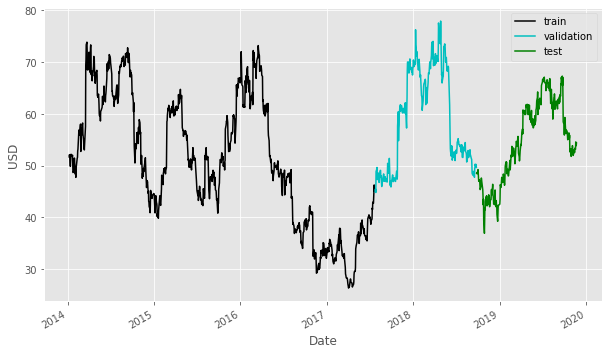

In [21]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

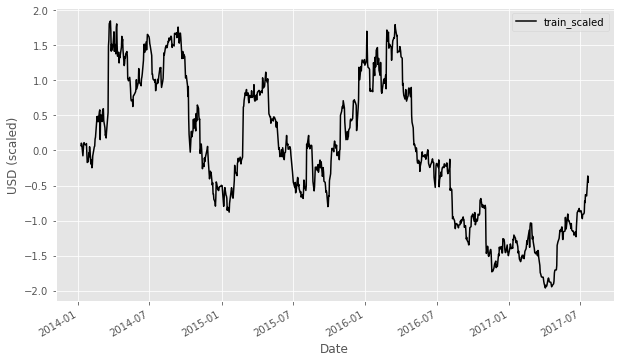

In [22]:
fig,ax=plt.subplots(figsize=(10,6))
ax = train_scaled.plot(x='date', y='adj_close', style='k-', ax=ax)
ax.legend(['train_scaled'])
ax.set_xlabel("Date")
ax.set_ylabel("USD (scaled)")
plt.show();

In [23]:
# Create the model
model = XGBRegressor(objective='reg:squarederror',
                     seed=seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [24]:
# Do prediction on train set
y_pred_scaled = model.predict(X_train_scaled)
y_pred = y_pred_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

m = forecast_metrics(y_train, y_pred)
print(m)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.007592  1.471362  1.470206  1.450204  0.996736


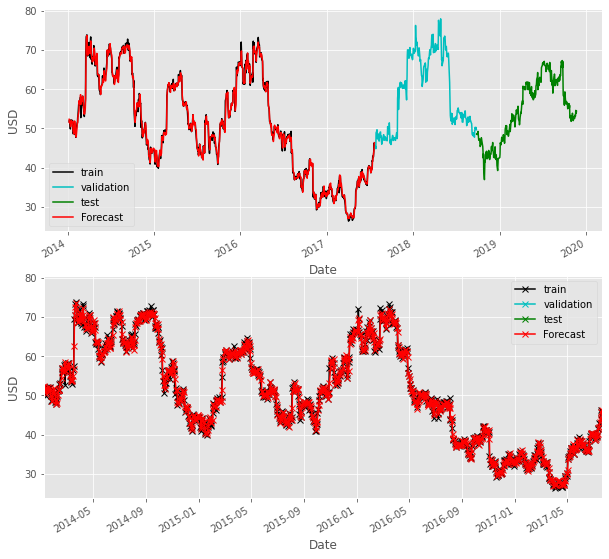

In [25]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(train.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(train.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([train.date.min(), train.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [26]:
# Do prediction on val set
y_pred_scaled = model.predict(X_val_scaled)
val['forecast_scaled'] = y_pred_scaled
val['forecast'] = val['forecast_scaled'] * val['adj_close_std'] + val['adj_close_mean']

m = forecast_metrics(y_val, val['forecast'])
print(m)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.617333  1.798184  1.801483  1.766762  0.985552


In [27]:
rmse_dryrun, mape_dryrun = m.RMSE[0], m.MAPE[0]

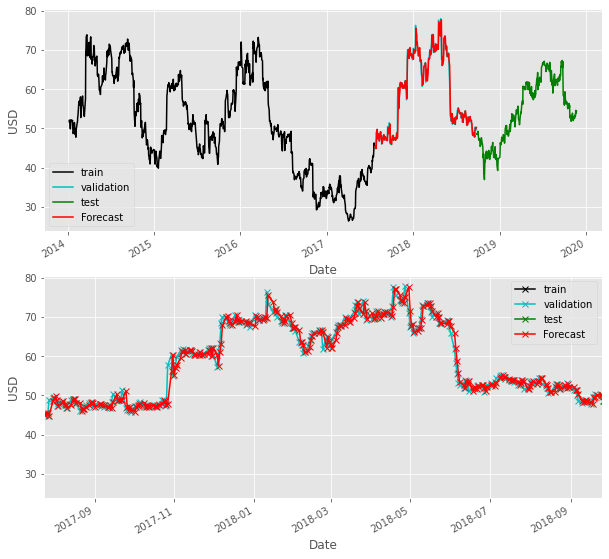

In [28]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, val['forecast'], 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, val['forecast'], 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [29]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:][::-1]

[('adj_close_lag_1', 0.8670035),
 ('adj_close_lag_2', 0.07003292),
 ('adj_close_lag_3', 0.021339197),
 ('adj_close_lag_4', 0.0035512461),
 ('volume_lag_1', 0.0035026518),
 ('range_oc_lag_3', 0.0033327474),
 ('range_hl_lag_4', 0.0031615302),
 ('range_oc_lag_1', 0.003078001),
 ('range_hl_lag_1', 0.0028150873),
 ('range_oc_lag_4', 0.0027376139)]

### Tuning N_opt

This will affect the scaling

        RMSE      MAPE     SMAPE    MinMax      Corr
2   1.619583  1.815086  1.818734  1.783844  0.985599
3   1.636632  1.829143  1.832522  1.796937  0.985239
4   1.617333  1.798184  1.801483  1.766762  0.985552
5   1.622945  1.814947  1.818957  1.783956  0.985372
6   1.652141  1.838753  1.842845  1.806532  0.984776
7   1.647283  1.824980  1.829126  1.793192  0.984818
8   1.651761  1.841455  1.845190  1.808997  0.984686
9   1.657718  1.831267  1.834760  1.798785  0.984548
10  1.681166  1.840178  1.843555  1.806553  0.984088
11  1.750041  1.903742  1.906487  1.866541  0.982767
12  1.756672  1.896855  1.901399  1.861192  0.982659
13  1.809596  1.933991  1.939274  1.896685  0.981598
14  1.761268  1.875007  1.879298  1.838879  0.982574
15  1.757279  1.874286  1.878482  1.838185  0.982677
16  1.783390  1.904899  1.907782  1.866133  0.982188
17  1.761721  1.872083  1.874245  1.833362  0.982653
18  1.774596  1.875122  1.877482  1.836087  0.982408
19  1.802938  1.921550  1.924186  1.881412  0.

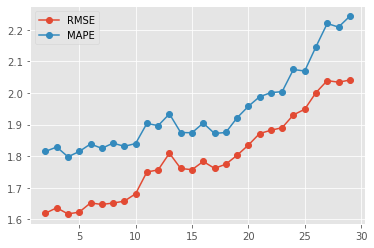

In [30]:
# this is a long cell, but I just copied the feature engineering codes here.
# should be a functional for a production code

metrics = pd.DataFrame()

for N in range(2,30):
    data = data_copy.copy()
    cols_list = "volume adj_close range_hl range_oc".split()
    lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

    for col in cols_list:
        data = get_mov_avg_std(data, col, N)

    data['order_day'] = list(range(len(data)))
    merging_keys = ['order_day']

    for shift in range(1,N+1):
        data_shift = data[merging_keys + lag_cols].copy()
        data_shift['order_day'] = data_shift['order_day'] + shift

        foo = lambda x: f'{x}_lag_{shift}' if x in lag_cols else x
        data_shift = data_shift.rename(columns=foo)

        data = pd.merge(data, data_shift, on=merging_keys, how='left')
    del data_shift

    # Remove the first N rows which contain NaNs
    data = data[N:]

    # number of test set decreased by N here
    train = data[:ntrain]
    val = data[ntrain:ntrain+nval]
    train_val = data[:ntrain+nval] # convinient
    test = data[ntrain+nval:]

    cols_to_scale = ["adj_close"]

    for i in range(1,N+1):
        cols_to_scale.append("adj_close_lag_"+str(i))
        cols_to_scale.append("range_hl_lag_"+str(i))
        cols_to_scale.append("range_oc_lag_"+str(i))
        cols_to_scale.append("volume_lag_"+str(i))


    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
    train_scaled[col_dates] = train.reset_index()[col_dates]

    # Do scaling for train+val set
    scaler_train_val = StandardScaler()
    train_val_scaled = scaler_train_val.fit_transform(train_val[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_val_scaled = pd.DataFrame(train_val_scaled, columns=cols_to_scale)
    train_val_scaled[col_dates] = train_val.reset_index()[col_dates]

    # Do scaling for val set
    val_scaled = val[col_dates]
    for col in cols_list:
        feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
        temp = val.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        val_scaled = pd.concat([val_scaled, temp], axis=1)

    test_scaled = test[col_dates]
    for col in cols_list:
        feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
        temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        test_scaled = pd.concat([test_scaled, temp], axis=1)

    features = list(col_dates[1:])
    for i in range(1,N+1):
        features.append("adj_close_lag_"+str(i))
        features.append("range_hl_lag_"+str(i))
        features.append("range_oc_lag_"+str(i))
        features.append("volume_lag_"+str(i))


    target = "adj_close"

    # Split into X and y
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    X_train_val = train_val[features]
    y_train_val = train_val[target]
    X_test = test[features]
    y_test = test[target]

    X_train_scaled = train_scaled[features]
    y_train_scaled = train_scaled[target]
    X_val_scaled = val_scaled[features]
    X_train_val_scaled = train_val_scaled[features]
    y_train_val_scaled = train_val_scaled[target]
    X_test_scaled = test_scaled[features]
    
    # Train, predict and eval model
    m, _ = train_pred_eval_model(X_train_scaled, 
                                 y_train_scaled, 
                                 X_val_scaled, 
                                 y_val, 
                                 val['adj_close_mean'],
                                 val['adj_close_std'],
                                 seed=seed,
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=learning_rate, 
                                 min_child_weight=min_child_weight, 
                                 subsample=subsample, 
                                 colsample_bytree=colsample_bytree, 
                                 colsample_bylevel=colsample_bylevel, 
                                 gamma=gamma,
                                 name=N)
    
    # collect metrics
    metrics = metrics.append(m)

print(metrics)
N_opt = metrics.MAPE.idxmin()
metrics[['RMSE', 'MAPE']].plot(style='o-');

In [31]:
# generate the data again

#N_opt = 4
for N in [N_opt]:
    data = data_copy.copy()
    cols_list = "volume adj_close range_hl range_oc".split()
    lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

    for col in cols_list:
        data = get_mov_avg_std(data, col, N)

    data['order_day'] = list(range(len(data)))
    merging_keys = ['order_day']

    for shift in range(1,N+1):
        data_shift = data[merging_keys + lag_cols].copy()
        data_shift['order_day'] = data_shift['order_day'] + shift

        foo = lambda x: f'{x}_lag_{shift}' if x in lag_cols else x
        data_shift = data_shift.rename(columns=foo)

        data = pd.merge(data, data_shift, on=merging_keys, how='left')
    del data_shift

    # Remove the first N rows which contain NaNs
    data = data[N:]

    # number of test set decreased by N here
    train = data[:ntrain]
    val = data[ntrain:ntrain+nval]
    train_val = data[:ntrain+nval] # convinient
    test = data[ntrain+nval:]

    cols_to_scale = ["adj_close"]

    for i in range(1,N+1):
        cols_to_scale.append("adj_close_lag_"+str(i))
        cols_to_scale.append("range_hl_lag_"+str(i))
        cols_to_scale.append("range_oc_lag_"+str(i))
        cols_to_scale.append("volume_lag_"+str(i))


    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
    train_scaled[col_dates] = train.reset_index()[col_dates]

    # Do scaling for train+val set
    scaler_train_val = StandardScaler()
    train_val_scaled = scaler_train_val.fit_transform(train_val[cols_to_scale])

    # Convert the numpy array back into pandas dataframe
    train_val_scaled = pd.DataFrame(train_val_scaled, columns=cols_to_scale)
    train_val_scaled[col_dates] = train_val.reset_index()[col_dates]

    # Do scaling for val set
    val_scaled = val[col_dates]
    for col in cols_list:
        feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
        temp = val.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        val_scaled = pd.concat([val_scaled, temp], axis=1)

    test_scaled = test[col_dates]
    for col in cols_list:
        feat_list = [f'{col}_lag_{shift}' for shift in range(1, N+1)]
        temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        test_scaled = pd.concat([test_scaled, temp], axis=1)

    features = list(col_dates[1:])
    for i in range(1,N+1):
        features.append("adj_close_lag_"+str(i))
        features.append("range_hl_lag_"+str(i))
        features.append("range_oc_lag_"+str(i))
        features.append("volume_lag_"+str(i))


    target = "adj_close"

    # Split into X and y
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    X_train_val = train_val[features]
    y_train_val = train_val[target]
    X_test = test[features]
    y_test = test[target]

    X_train_scaled = train_scaled[features]
    y_train_scaled = train_scaled[target]
    X_val_scaled = val_scaled[features]
    X_train_val_scaled = train_val_scaled[features]
    y_train_val_scaled = train_val_scaled[target]
    X_test_scaled = test_scaled[features]

### Tuning xgboost parameters

In [32]:
param_label = 'n_estimators'
param_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)
n_estimators_opt, max_depth_opt = metrics.MAPE.idxmin()

              RMSE      MAPE     SMAPE    MinMax      Corr
(10, 2)   1.704857  1.903129  1.899241  1.860947  0.984121
(10, 3)   1.707353  1.906300  1.901778  1.863415  0.984097
(10, 4)   1.712530  1.910625  1.906276  1.867687  0.983979
(10, 5)   1.715172  1.916170  1.911917  1.873243  0.983917
(10, 6)   1.718785  1.922321  1.917952  1.879128  0.983847
...            ...       ...       ...       ...       ...
(500, 5)  1.613319  1.804700  1.807798  1.773323  0.985608
(500, 6)  1.611946  1.806526  1.809520  1.775031  0.985625
(500, 7)  1.611391  1.807453  1.810328  1.775926  0.985650
(500, 8)  1.608270  1.805528  1.808603  1.774345  0.985700
(500, 9)  1.614990  1.811638  1.814895  1.780396  0.985576

[104 rows x 5 columns]


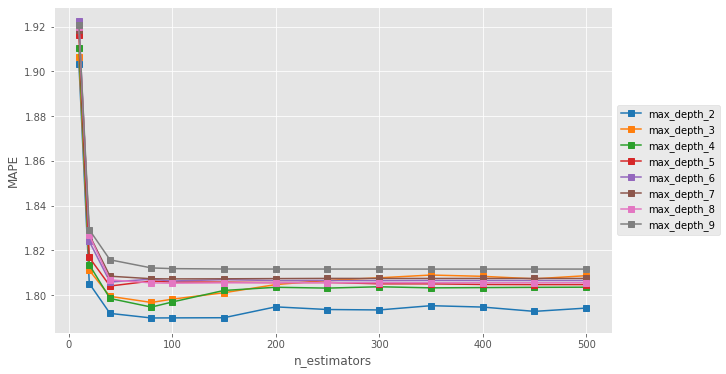

((80, 2), 1.7897872853483734)

In [33]:
plot_two_params_tuning(metrics, param_label, param2_label)
metrics.MAPE.idxmin(), metrics.MAPE.min()

In [34]:
param_label = 'learning_rate'
param_list = [0.1]  # fixed at first

param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=param2)
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt = 0.1
min_child_weight_opt = metrics.MAPE.idxmin()
metrics.MAPE.idxmin(), metrics.MAPE.min()

        RMSE      MAPE     SMAPE    MinMax      Corr
1   1.604281  1.789787  1.793196  1.759037  0.985778
2   1.604329  1.790455  1.793661  1.759500  0.985782
3   1.604369  1.790386  1.793581  1.759419  0.985781
4   1.604377  1.790328  1.793501  1.759339  0.985781
5   1.604747  1.791098  1.794387  1.760219  0.985773
6   1.605874  1.791956  1.795082  1.760863  0.985754
7   1.604296  1.790642  1.793930  1.759771  0.985780
8   1.604670  1.790847  1.794137  1.759959  0.985773
9   1.604978  1.791290  1.794538  1.760352  0.985768
10  1.604344  1.789911  1.793244  1.759090  0.985779
11  1.604812  1.790216  1.793560  1.759389  0.985769
12  1.604467  1.789806  1.793256  1.759089  0.985775
13  1.603217  1.789055  1.792564  1.758449  0.985797
14  1.601171  1.787970  1.791423  1.757380  0.985833
15  1.600809  1.787708  1.791258  1.757240  0.985840
16  1.601012  1.787757  1.791374  1.757347  0.985835
17  1.602250  1.788515  1.791923  1.757854  0.985815
18  1.602876  1.789810  1.793208  1.759102  0.

(15, 1.7877081656327496)

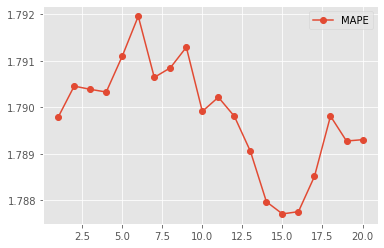

In [35]:
metrics.plot(y=['MAPE'], style='o-');

In [36]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)

param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

subsample_opt, gamma_opt = metrics.MAPE.idxmin()
metrics.MAPE.idxmin(), metrics.MAPE.min()

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.1, 0.1)  1.623897  1.818720  1.824293  1.789245  0.985395
(0.1, 0.2)  1.627805  1.820027  1.825298  1.790132  0.985328
(0.1, 0.3)  1.625781  1.819031  1.824104  1.789026  0.985366
(0.1, 0.4)  1.625136  1.819929  1.825120  1.790060  0.985377
(0.1, 0.5)  1.626646  1.820961  1.825968  1.790844  0.985350
...              ...       ...       ...       ...       ...
(1, 0.6)    1.656688  1.843642  1.847111  1.810846  0.984798
(1, 0.7)    1.657427  1.844491  1.847957  1.811663  0.984784
(1, 0.8)    1.658286  1.844895  1.848358  1.812022  0.984769
(1, 0.9)    1.658601  1.845749  1.849320  1.812981  0.984762
(1, 1)      1.657447  1.844724  1.848300  1.812006  0.984783

[100 rows x 5 columns]


((0.7, 0.1), 1.7857066353603444)

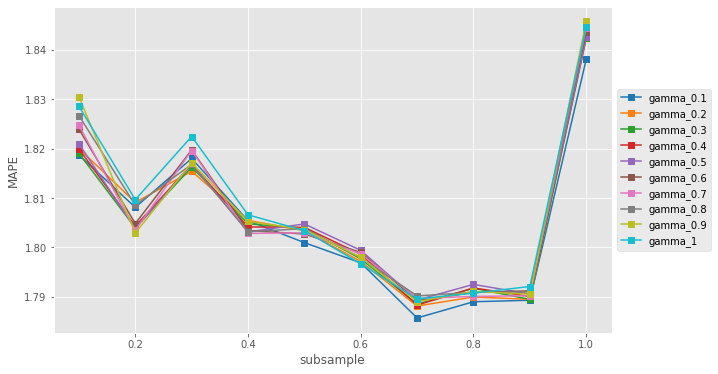

In [37]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [38]:
### Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

colsample_bytree_opt, colsample_bylevel_opt = metrics.MAPE.idxmin()
metrics.MAPE.idxmin(), metrics.MAPE.min()

                RMSE      MAPE     SMAPE    MinMax      Corr
(0.5, 0.5)  1.918573  2.118682  2.123524  2.075520  0.979538
(0.5, 0.6)  1.874334  2.077340  2.081031  2.034958  0.980473
(0.5, 0.7)  1.821872  2.030681  2.035884  1.992259  0.981559
(0.5, 0.8)  1.798889  2.008444  2.013471  1.970902  0.982022
(0.5, 0.9)  1.765942  1.976205  1.981283  1.940152  0.982679
(0.5, 1)    1.687321  1.888639  1.892395  1.854749  0.984207
(0.6, 0.5)  1.756688  1.966536  1.969134  1.928361  0.982863
(0.6, 0.6)  1.731945  1.935419  1.938720  1.899106  0.983343
(0.6, 0.7)  1.712965  1.915661  1.918548  1.879775  0.983713
(0.6, 0.8)  1.668912  1.871261  1.875577  1.838745  0.984544
(0.6, 0.9)  1.675528  1.877055  1.880026  1.842875  0.984431
(0.6, 1)    1.664896  1.865165  1.868434  1.831729  0.984632
(0.7, 0.5)  1.824168  2.034700  2.040955  1.997259  0.981497
(0.7, 0.6)  1.814474  2.021283  2.027992  1.984837  0.981704
(0.7, 0.7)  1.754050  1.955770  1.961840  1.921513  0.982914
(0.7, 0.8)  1.712272  1.

((1, 1), 1.7852574353057518)

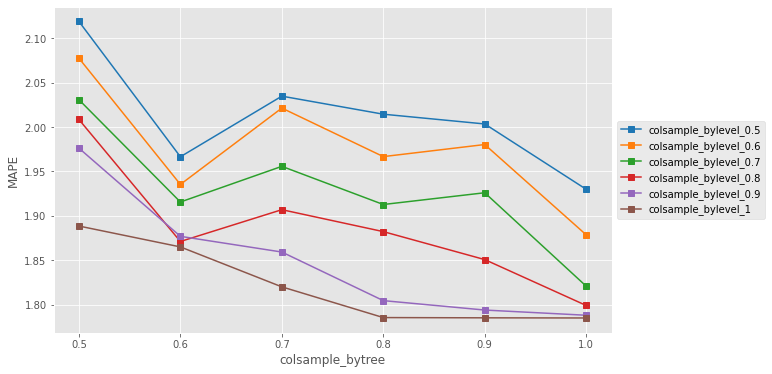

In [39]:
plot_two_params_tuning(metrics, param_label, param2_label)

In [45]:
### Tuning XGBoost - final learning_rate and n_estimators, they should be optimized together

param_label = 'learning_rate'
param_list = [0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

param2_label = 'n_estimators'
param2_list = [10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['adj_close_mean'],
                                     val['adj_close_std'],
                                     seed=seed,
                                     n_estimators=param2, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=colsample_bytree_opt, 
                                     colsample_bylevel=colsample_bylevel_opt, 
                                     gamma=gamma_opt,
                                     name=(param, param2))
    
        # collect metrics
        metrics = metrics.append(m)

print(metrics)

learning_rate_opt, n_estimators_opt = metrics.MAPE.idxmin()
metrics.MAPE.idxmin(), metrics.MAPE.min()

                  RMSE      MAPE     SMAPE    MinMax      Corr
(0.001, 10)   2.275400  2.537346  2.509448  2.443608  0.973129
(0.001, 20)   2.263968  2.524807  2.497418  2.432197  0.973376
(0.001, 40)   2.241630  2.500106  2.473709  2.409691  0.973856
(0.001, 80)   2.199584  2.453048  2.428502  2.366720  0.974746
(0.001, 100)  2.180057  2.430973  2.407291  2.346535  0.975153
...                ...       ...       ...       ...       ...
(0.3, 300)    1.606336  1.789024  1.792592  1.758330  0.985752
(0.3, 350)    1.606872  1.789721  1.793239  1.758955  0.985743
(0.3, 400)    1.608237  1.790331  1.793932  1.759601  0.985717
(0.3, 450)    1.608609  1.791137  1.794621  1.760271  0.985711
(0.3, 500)    1.607007  1.789900  1.793497  1.759210  0.985739

[117 rows x 5 columns]


((0.25, 350), 1.7822202933124496)

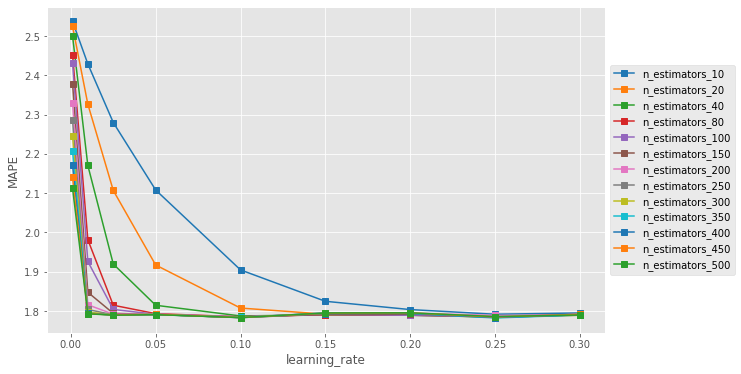

In [46]:
plot_two_params_tuning(metrics, param_label, param2_label)

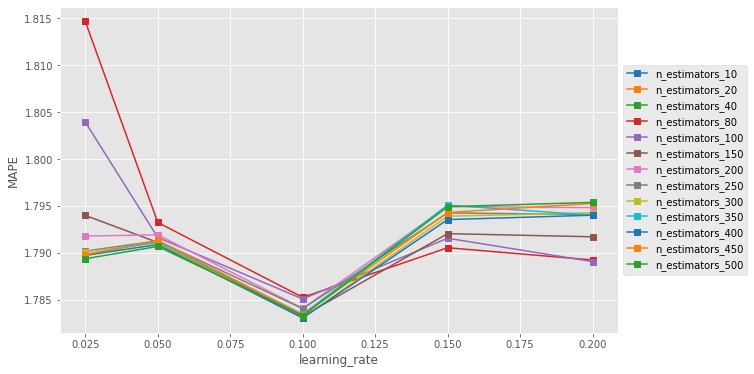

In [48]:
# lr = 0.25 seems too big
plot_two_params_tuning(metrics[  (metrics['n_estimators']>40) 
                               & (metrics['learning_rate']>0.01) 
                               & (metrics['learning_rate']<0.25)], 
                       param_label, param2_label)

In [53]:
metrics[metrics.learning_rate==0.1].sort_values(by='MAPE')

,RMSE,MAPE,SMAPE,MinMax,Corr,learning_rate,n_estimators
"(0.1, 400)",1.598623,1.783058,1.786616,1.752693,0.985873,0.1,400.0
"(0.1, 300)",1.598574,1.783073,1.786554,1.752632,0.985874,0.1,300.0
"(0.1, 150)",1.597771,1.783251,1.786965,1.753066,0.985885,0.1,150.0
"(0.1, 500)",1.598646,1.783314,1.786913,1.752991,0.985873,0.1,500.0
"(0.1, 450)",1.598789,1.783406,1.786966,1.753034,0.985870,0.1,450.0
"(0.1, 350)",1.598976,1.783460,1.786904,1.752967,0.985867,0.1,350.0
"(0.1, 250)",1.599526,1.784055,1.787420,1.753461,0.985857,0.1,250.0
"(0.1, 200)",1.598902,1.784077,1.787634,1.753694,0.985866,0.1,200.0
"(0.1, 100)",1.599384,1.785081,1.788675,1.754703,0.985858,0.1,100.0
"(0.1, 80)",1.598820,1.785257,1.788690,1.754735,0.985869,0.1,80.0


In [54]:
learning_rate_opt, n_estimators_opt = 0.1, 300

### Final model, test set

In [55]:
metrics, y_pred = train_pred_eval_model(X_train_val_scaled, 
                             y_train_val_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt,
                             name='XGBoost')

print(metrics)

             RMSE      MAPE     SMAPE    MinMax      Corr
XGBoost  1.259114  1.750104  1.747075  1.719344  0.987003


### Plotting on test set

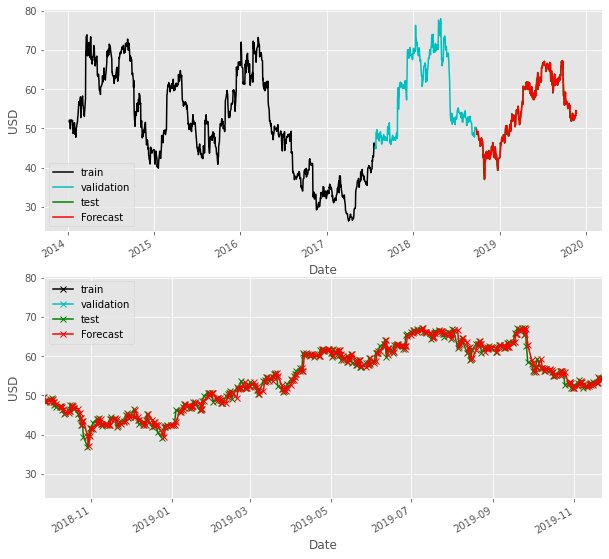

In [56]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [57]:
test[f'forcast'] = y_pred
test.to_csv("./out/test_xgboost_dt.csv")

In [58]:
print(metrics)

             RMSE      MAPE     SMAPE    MinMax      Corr
XGBoost  1.259114  1.750104  1.747075  1.719344  0.987003


In [59]:
# Create the model
model = XGBRegressor(objective='reg:squarederror',
                     seed=seed,
                     n_estimators=n_estimators_opt, 
                     max_depth=max_depth_opt, 
                     learning_rate=learning_rate_opt, 
                     min_child_weight=min_child_weight_opt, 
                     subsample=subsample_opt, 
                     colsample_bytree=colsample_bytree_opt, 
                     colsample_bylevel=colsample_bylevel_opt, 
                     gamma=gamma_opt
                    )

# Train the regressor
model.fit(X_train_val_scaled, y_train_val_scaled)

# Do prediction on val set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled  * test['adj_close_std'] + test['adj_close_mean']

m = forecast_metrics(y_test, y_pred)
print(m)

# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-20:][::-1]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=15, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.7, verbosity=1)

          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.259114  1.750104  1.747075  1.719344  0.987003


[('adj_close_lag_1', 0.8571867),
 ('adj_close_lag_2', 0.0820402),
 ('adj_close_lag_4', 0.020172775),
 ('range_hl_lag_2', 0.003334119),
 ('range_hl_lag_4', 0.003264548),
 ('month', 0.0031914006),
 ('range_oc_lag_3', 0.0028841312),
 ('range_oc_lag_1', 0.0028347503),
 ('volume_lag_2', 0.0027851805),
 ('range_hl_lag_3', 0.002765914),
 ('adj_close_lag_3', 0.0027262517),
 ('volume_lag_4', 0.0025724215),
 ('range_oc_lag_4', 0.0025697127),
 ('volume_lag_3', 0.00245683),
 ('dayofweek', 0.002397982),
 ('volume_lag_1', 0.0023952536),
 ('range_hl_lag_1', 0.0022639248),
 ('range_oc_lag_2', 0.002157861),
 ('is_year_start', 0.0),
 ('is_year_end', 0.0)]

In [61]:
# 'month' and 'dayofwork' seems useful